In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

In [3]:
# Connexion
con = duckdb.connect("football.duckdb")

# Sécurité mémoire
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='4GB';")

print("DuckDB ready")

DuckDB ready


In [4]:
con.execute("""
CREATE OR REPLACE VIEW tracking_v1 AS
SELECT
    session_type,
    session_date,
    player_id AS sensor_id,
    time_utc,
    x_pos,
    y_pos,
    latitude,
    longitude,
    speed_kmh
FROM tracking
""")

In [6]:
df_map = (
    pd.read_csv("data/summary.csv", sep=",")
    .assign(
        session_date=lambda x: pd.to_datetime(
            x["date"],
            format="%Y-%m-%d %H:%M:%S",
            errors="raise"   
        ).dt.date
    )
    .rename(columns={
        "Sensor": "sensor_id",
        "last_name": "player_id"
    })
    [["session_date", "sensor_id", "player_id"]]
    .drop_duplicates()
)

print(df_map.head())

con.register("sensor_player_map", df_map)

con.execute("""
CREATE OR REPLACE VIEW mapping_v AS
SELECT * FROM sensor_player_map
""")

  session_date  sensor_id  player_id
0   2020-02-01          4   KNEZEVIC
1   2020-02-01          5      ALVES
2   2020-02-01          9  MARGIOTTA
3   2020-02-01         10      ELEKE
4   2020-02-01         11    SCHURPF


In [7]:
con.execute("""
CREATE OR REPLACE VIEW tracking_v2 AS
SELECT
    t.*,
    m.player_id
FROM tracking_v1 t
LEFT JOIN mapping_v m
ON t.sensor_id = m.sensor_id
AND t.session_date = m.session_date
""")

In [9]:
unmapped = con.execute("""
SELECT
    session_date,
    sensor_id,
    COUNT(*) AS n_rows
FROM tracking_v2
WHERE player_id IS NULL
GROUP BY session_date, sensor_id
ORDER BY n_rows DESC
""").df()

print(unmapped.head())

  session_date  sensor_id  n_rows
0   2019-10-10          7   36851


Étant donné que sur le capteur 7 plusieurs personnes ont été attribuées, je ne peux pas définir cette session à quelqu'un.

In [10]:
con.execute("""
CREATE OR REPLACE TABLE tracking_player AS
SELECT *
FROM tracking_v2
WHERE player_id IS NOT NULL;
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [16]:
summary = con.execute("""
SELECT
    COUNT(*) AS n_rows,
    COUNT(DISTINCT player_id) AS n_players,
    COUNT(DISTINCT session_date) AS n_sessions,
    COUNT(DISTINCT sensor_id) AS n_sensors
FROM tracking_player
""").df()
summary2 = con.execute("""
SELECT
    session_type,
    COUNT(DISTINCT session_date) AS n_sessions
FROM tracking_player
GROUP BY session_type;
""").df()

print(summary)
print(summary2)

      n_rows  n_players  n_sessions  n_sensors
0  166541023         42         258         29
  session_type  n_sessions
0     practice         187
1         game          74


Pseudonomisation

In [41]:
# Extraire les joueurs
player = con.execute("""
SELECT DISTINCT player_id
FROM tracking_player
""").df()

# Attribuer un numéro à chaque joueur
player['player_number'] = np.arange(1, len(player) + 1)

# Sauvegarder le mapping
player.to_csv("data/player_numbering.txt", index=False, header=True)

# Créer une table temporaire dans DuckDB
con.register("player_numbered", player)

# Récupérer tous les noms de colonnes sauf player_id
cols = con.execute("PRAGMA table_info(tracking_player)").df()
cols = [c for c in cols['name'] if c != 'player_id']
cols_sql = ", ".join([f"tp.{c}" for c in cols])

# Créer la vue avec le pseudo
con.execute(f"""
CREATE OR REPLACE VIEW tracking_pseudo AS
SELECT
    {cols_sql},
    pn.player_number AS player_pseudo
FROM tracking_player tp
JOIN player_numbered pn ON tp.player_id = pn.player_id
""")


In [42]:
#Afficher view tracking_pseudo
df_pseudo = con.execute("""
SELECT * FROM tracking_pseudo LIMIT 50
""").df()
print(df_pseudo)

   session_type session_date  sensor_id                time_utc      x_pos  \
0          game   2020-07-02         11 2020-07-02 19:49:00.300  57.285480   
1          game   2020-07-02         11 2020-07-02 19:49:00.400  57.138852   
2          game   2020-07-02         11 2020-07-02 19:49:00.500  56.993699   
3          game   2020-07-02         11 2020-07-02 19:49:00.600  56.822725   
4          game   2020-07-02         11 2020-07-02 19:49:00.700  56.671116   
5          game   2020-07-02         11 2020-07-02 19:49:00.800  56.544960   
6          game   2020-07-02         11 2020-07-02 19:49:00.900  56.394088   
7          game   2020-07-02         11 2020-07-02 19:49:01.000  56.274387   
8          game   2020-07-02         11 2020-07-02 19:49:01.100  56.136425   
9          game   2020-07-02         11 2020-07-02 19:49:01.200  55.999569   
10         game   2020-07-02         11 2020-07-02 19:49:01.300  55.892410   
11         game   2020-07-02         11 2020-07-02 19:49:01.400 

## Clean vitesse abérante

In [47]:
#Seuil de vitesse max à 45 km/h
con.execute(f"""
CREATE OR REPLACE VIEW extreme_vitesse AS
SELECT
    player_pseudo,
    session_date,
            sensor_id,
    MAX(speed_kmh) AS max_speed
FROM tracking_pseudo
GROUP BY player_pseudo, session_date, sensor_id
HAVING MAX(speed_kmh) > 45;
""").df()
clean_vitesse = con.execute("""
SELECT *
FROM extreme_vitesse
ORDER BY max_speed DESC
""").df()
print(clean_vitesse)

    player_pseudo session_date  sensor_id  max_speed
0              20   2020-01-24         12  166.08996
1              33   2020-11-18         14  149.78448
2               9   2020-09-16          7  147.07368
3               1   2019-09-14         14  122.18940
4              24   2019-07-11          3  108.66240
5              37   2019-09-18         21   85.11228
6              15   2020-11-11          4   79.58520
7               4   2020-03-04         10   73.07172
8              15   2021-01-08          4   69.80580
9              16   2021-01-11         25   69.73056
10             19   2021-01-08         27   69.29136
11             39   2021-01-08          9   69.05196
12             35   2020-02-06          9   68.07708
13              5   2021-01-08         10   66.98268
14             36   2020-02-06         77   66.55104
15             34   2021-01-08          5   66.24900
16             13   2021-01-08         17   63.87624
17             18   2020-02-06         11   63

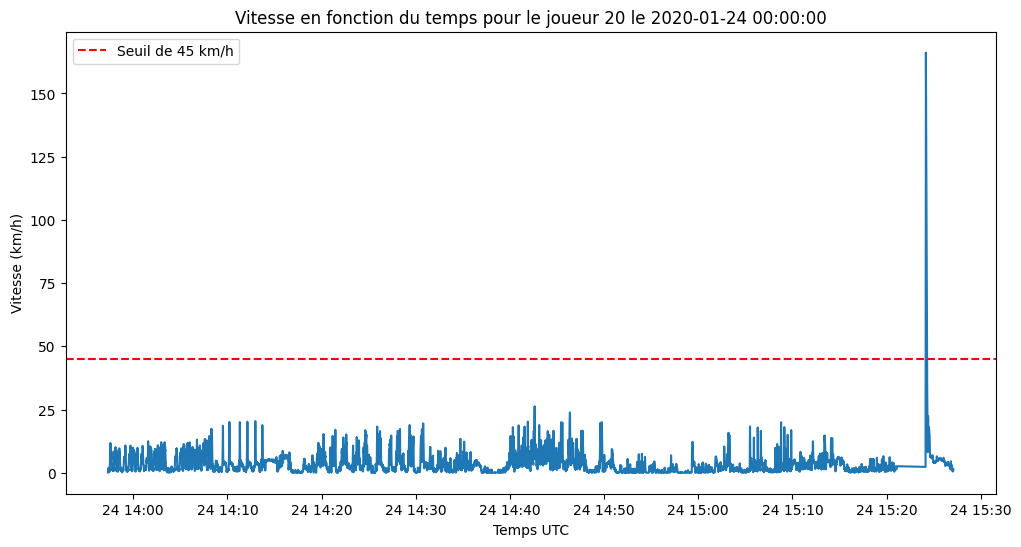

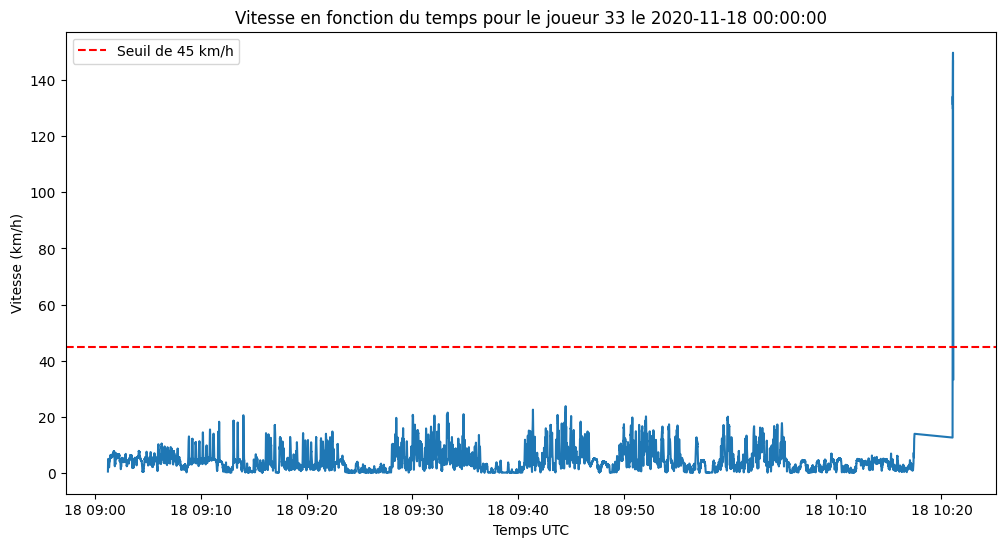

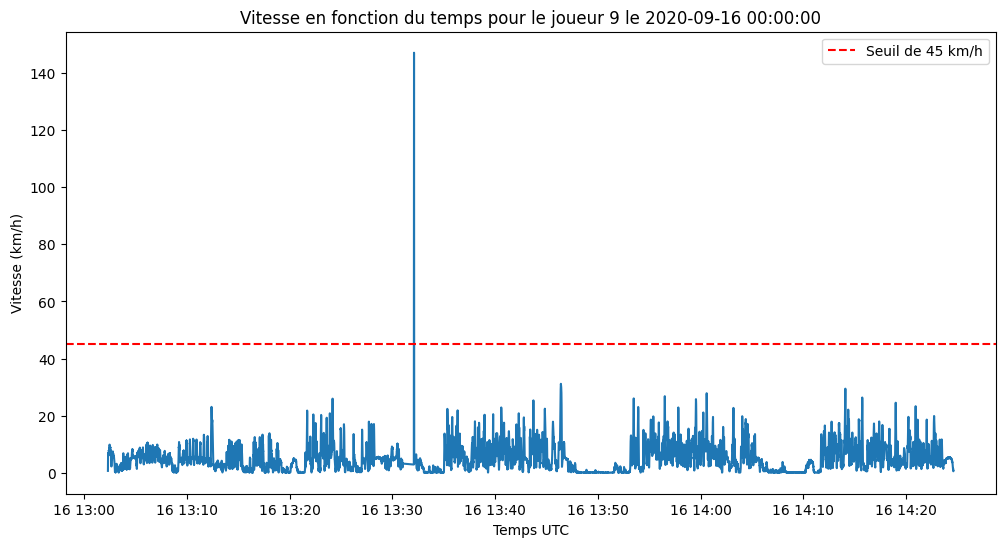

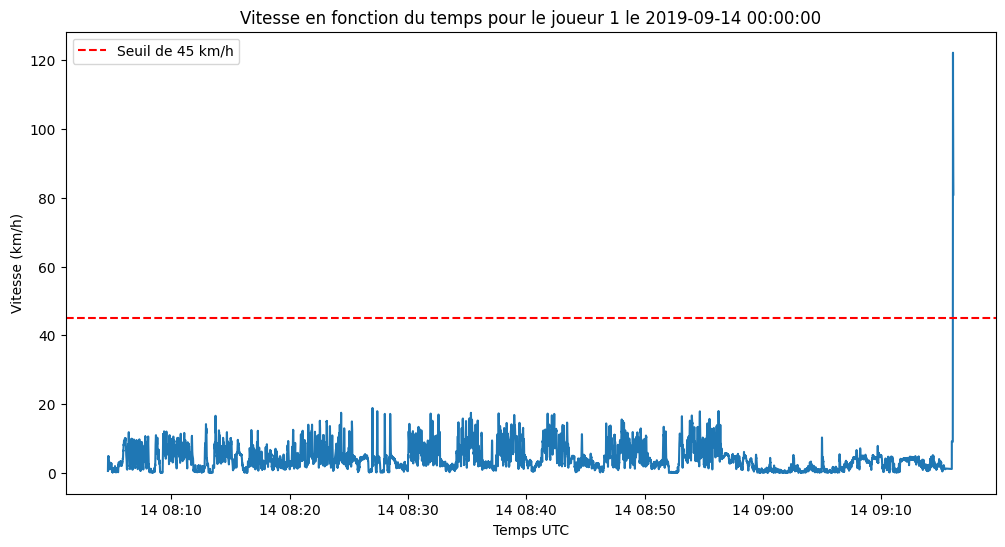

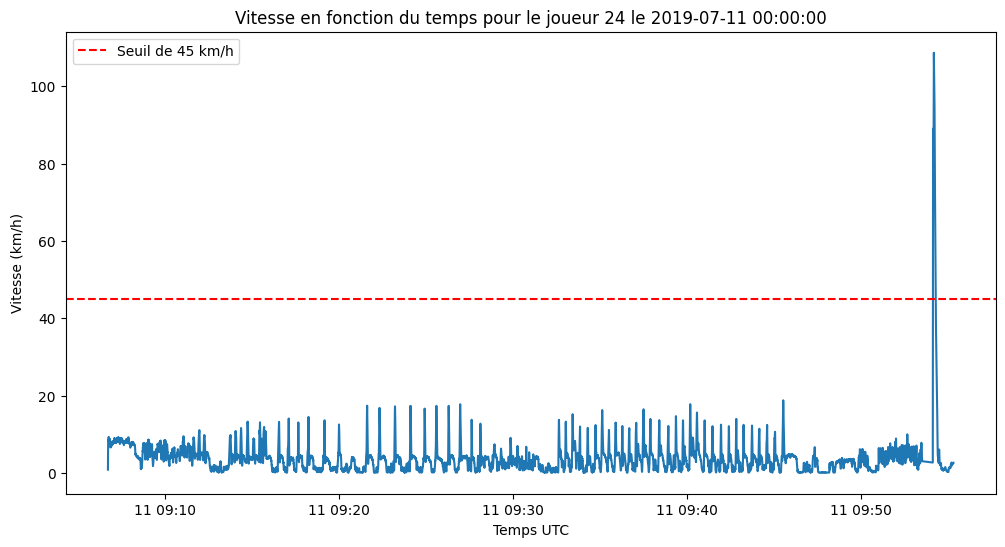

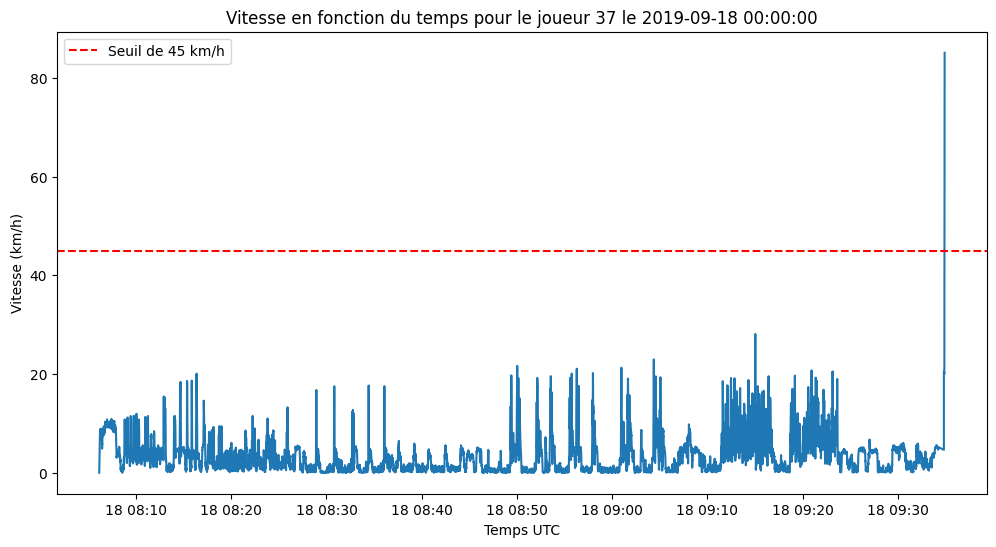

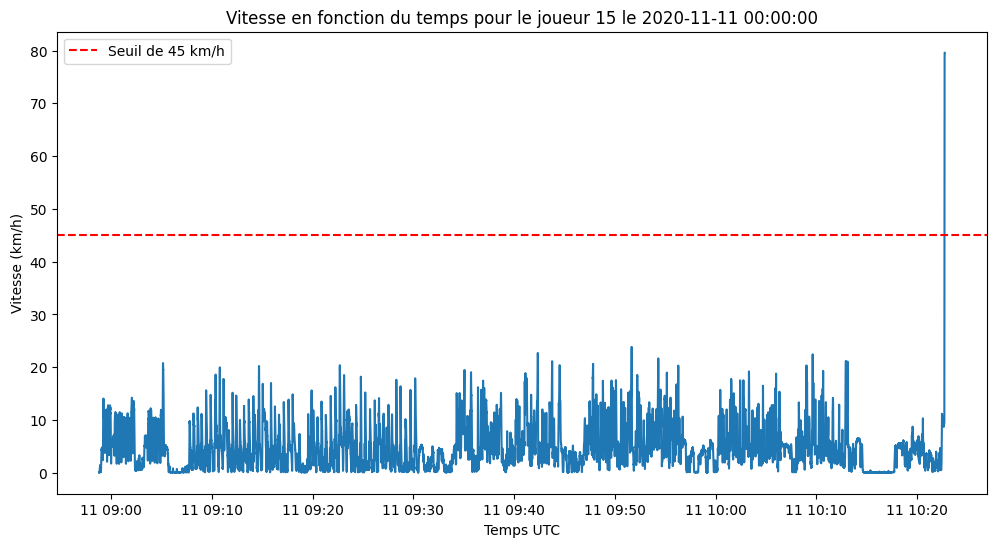

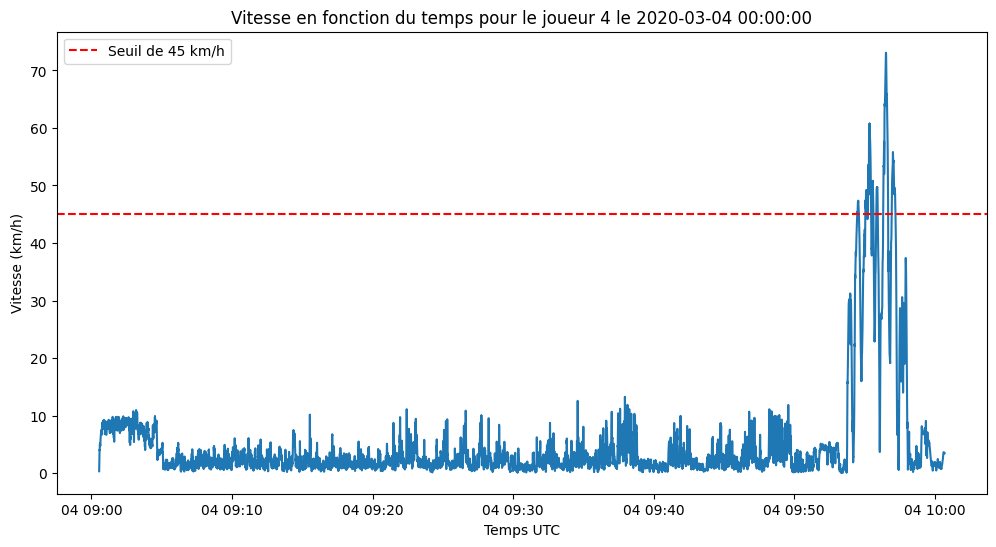

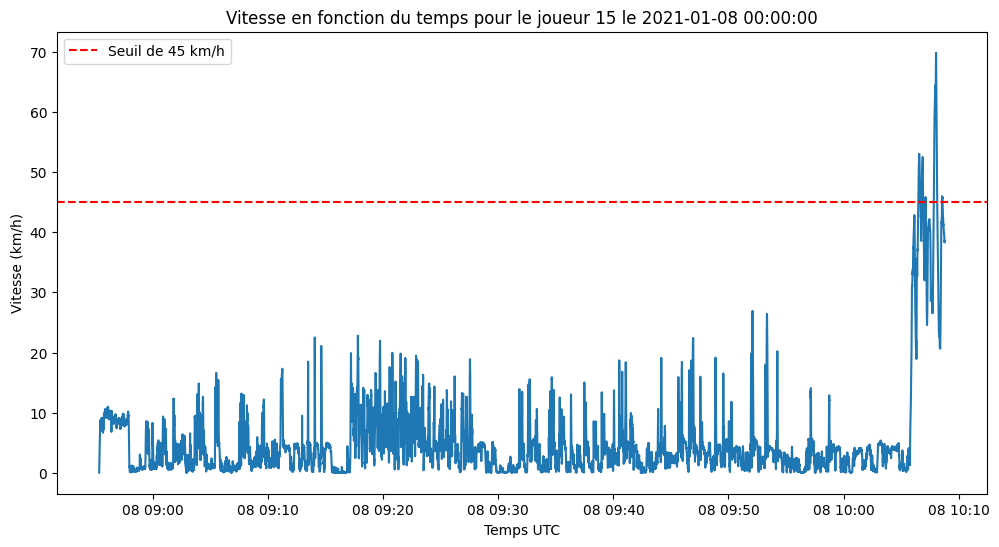

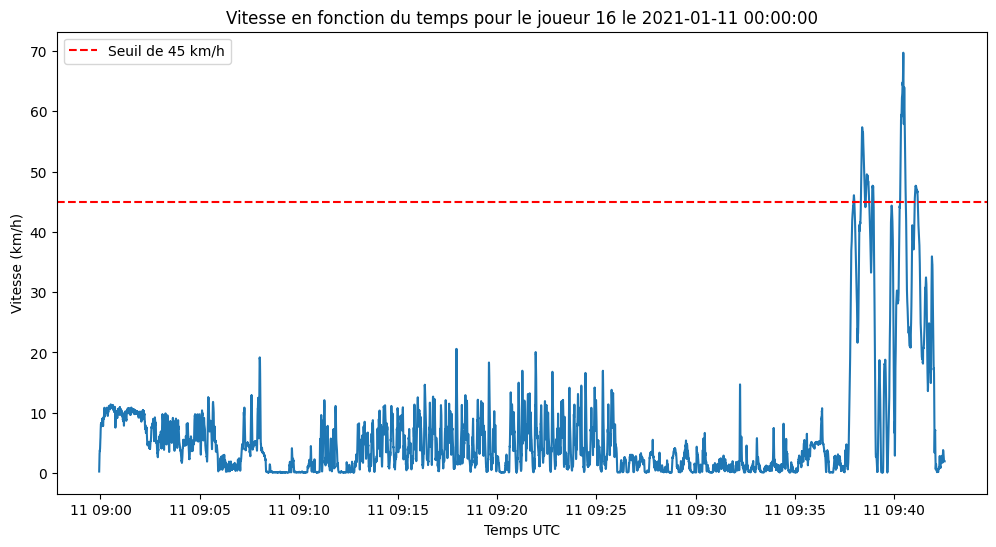

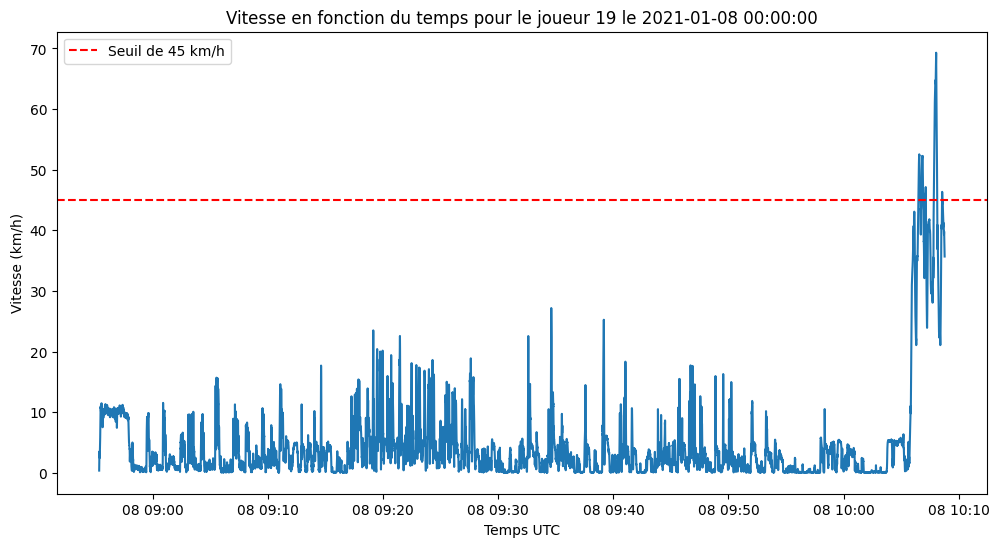

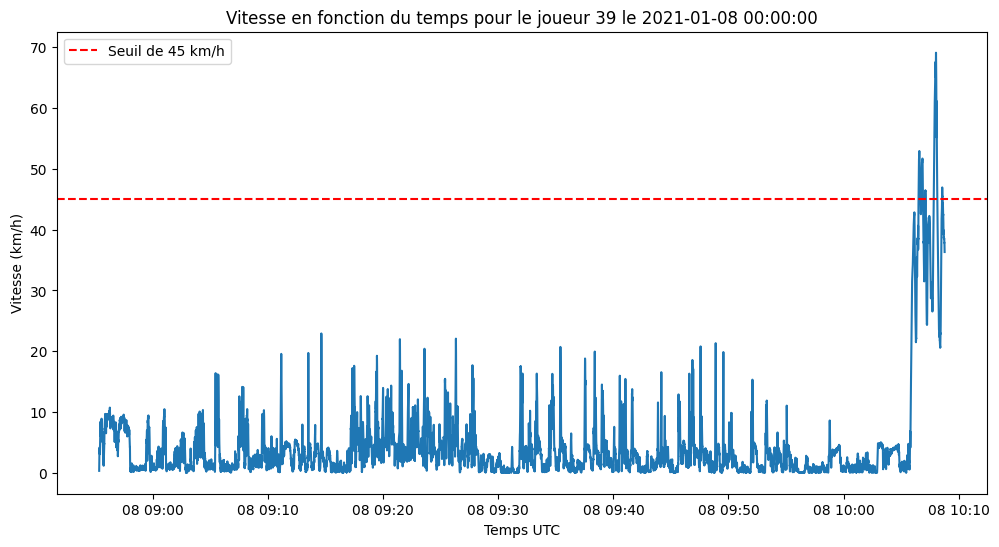

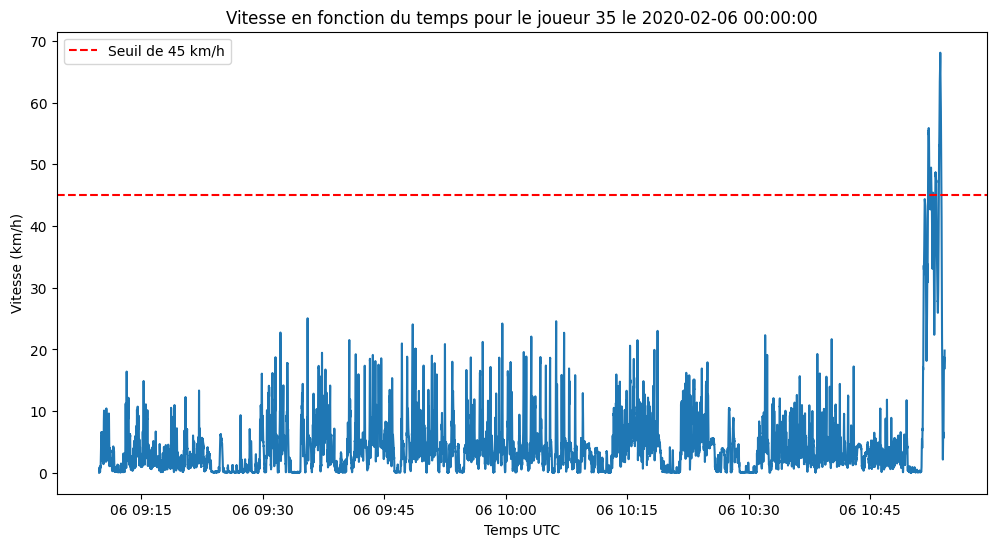

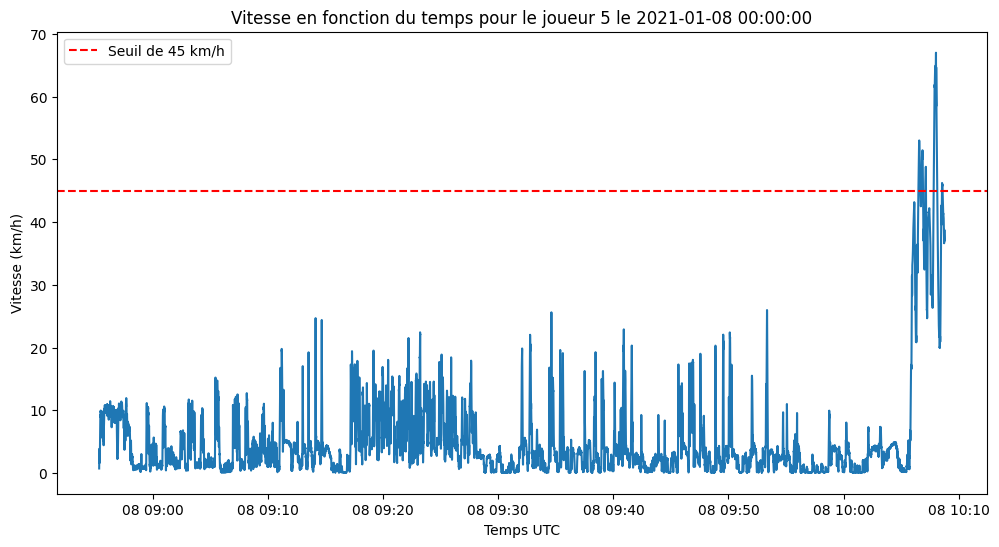

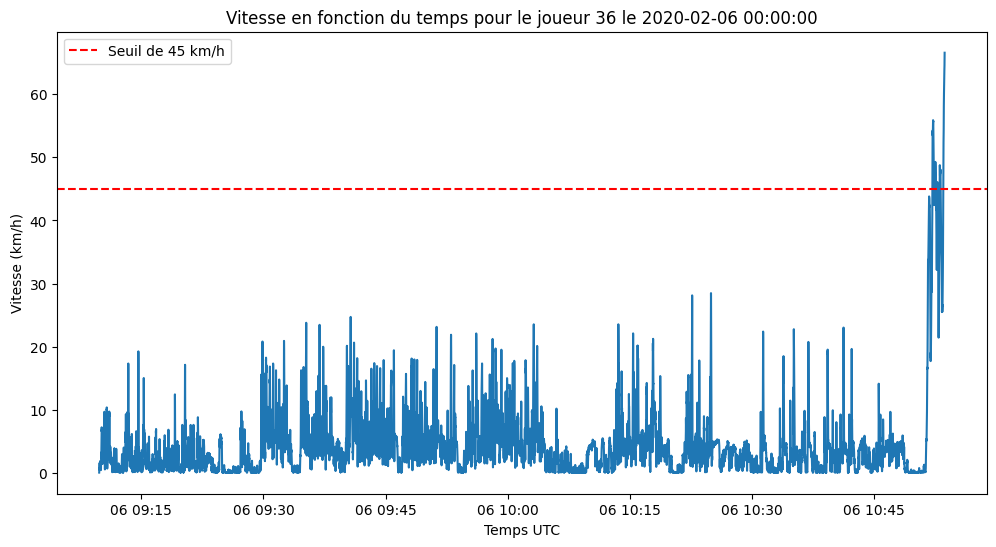

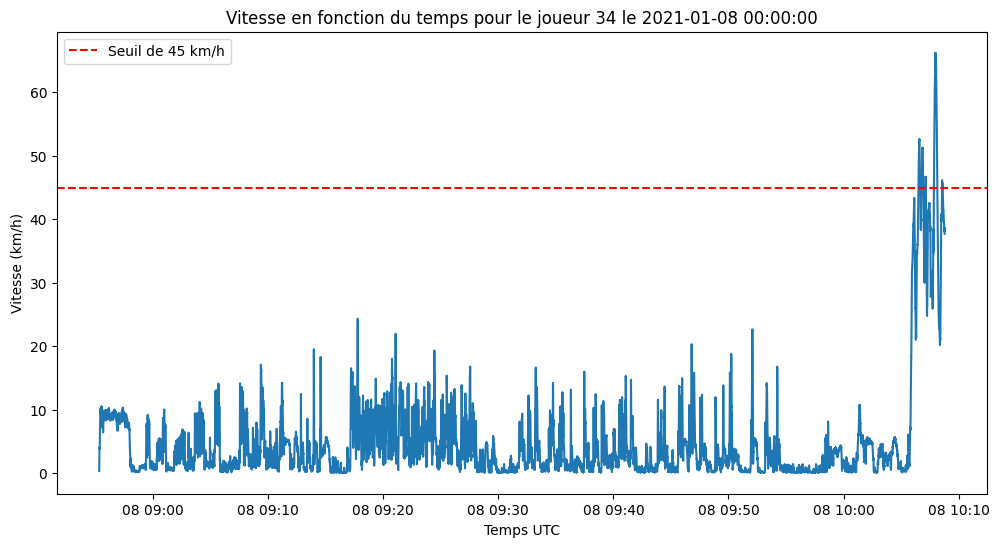

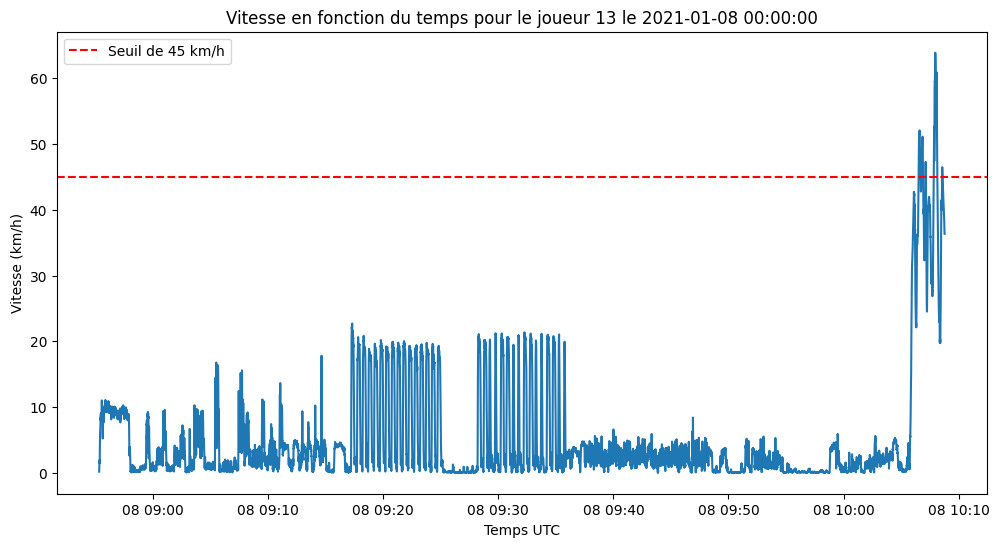

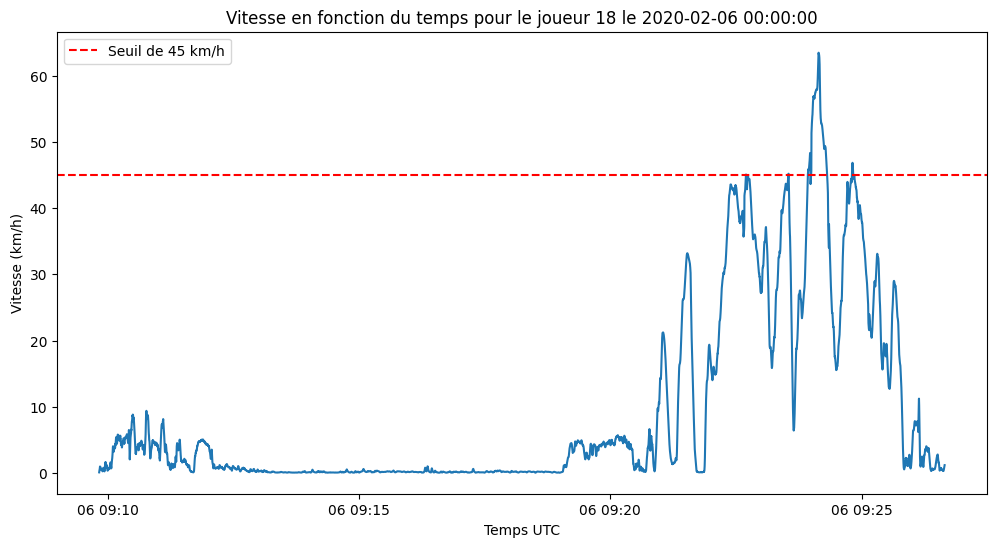

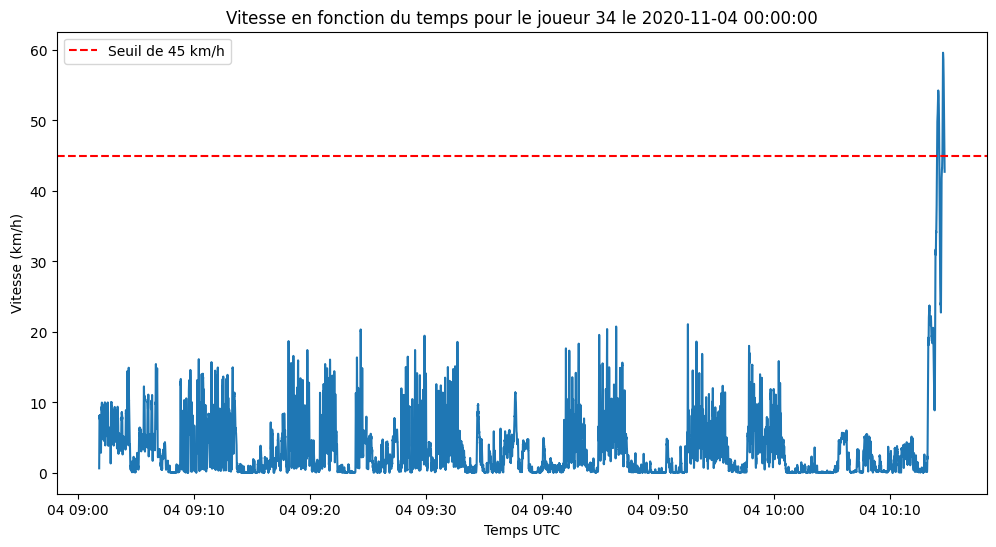

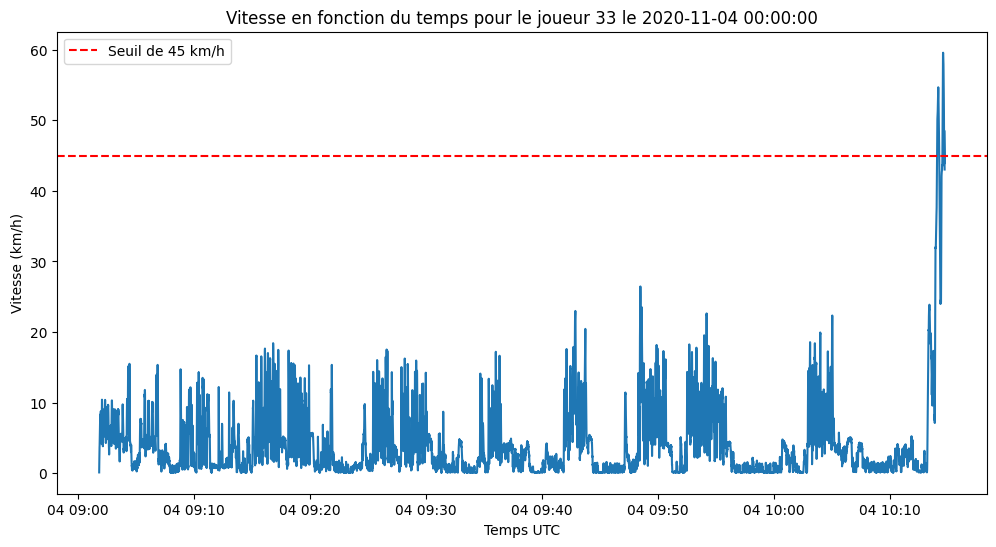

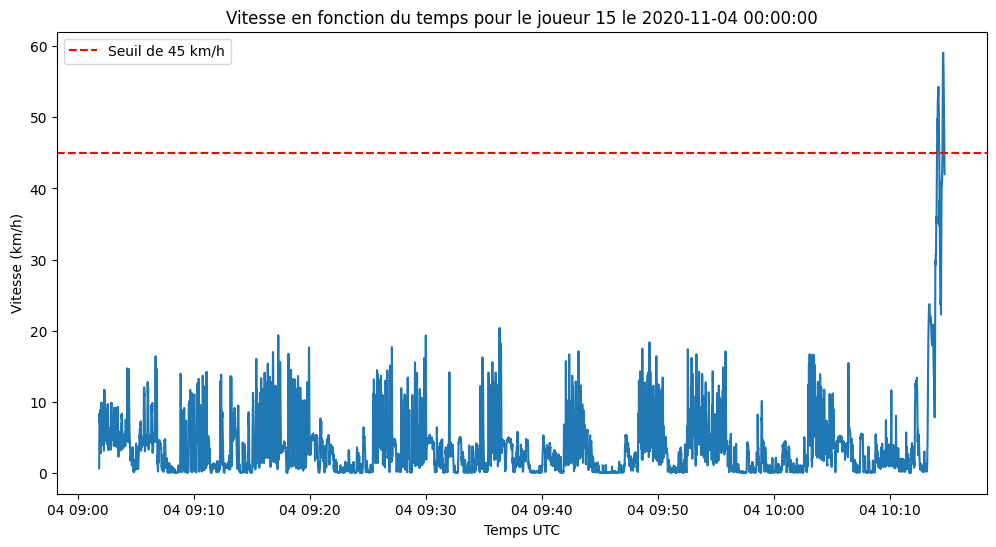

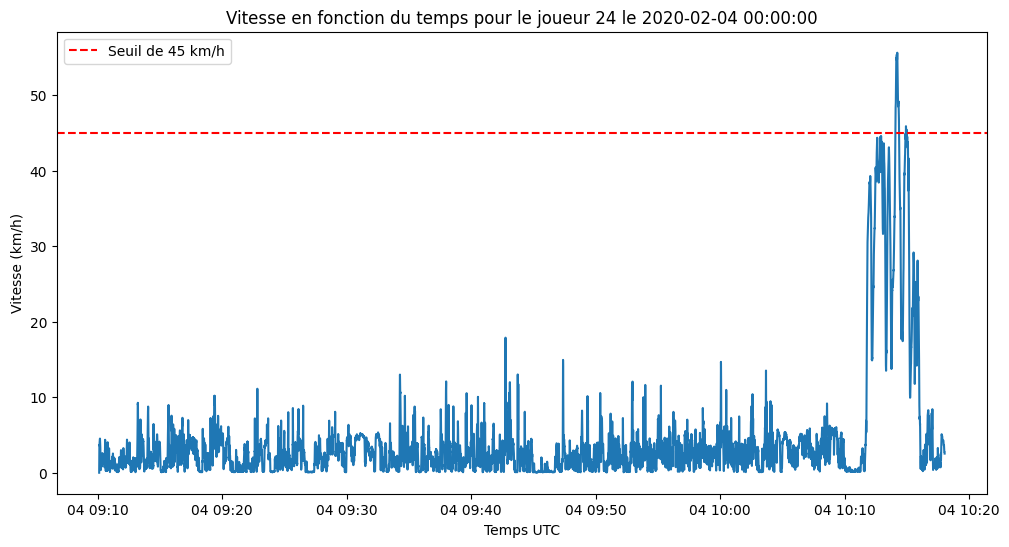

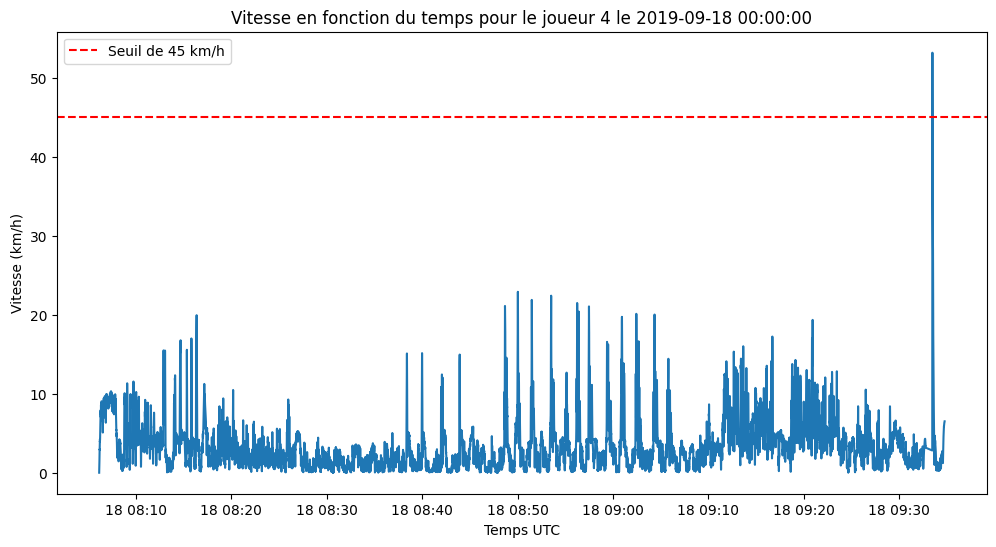

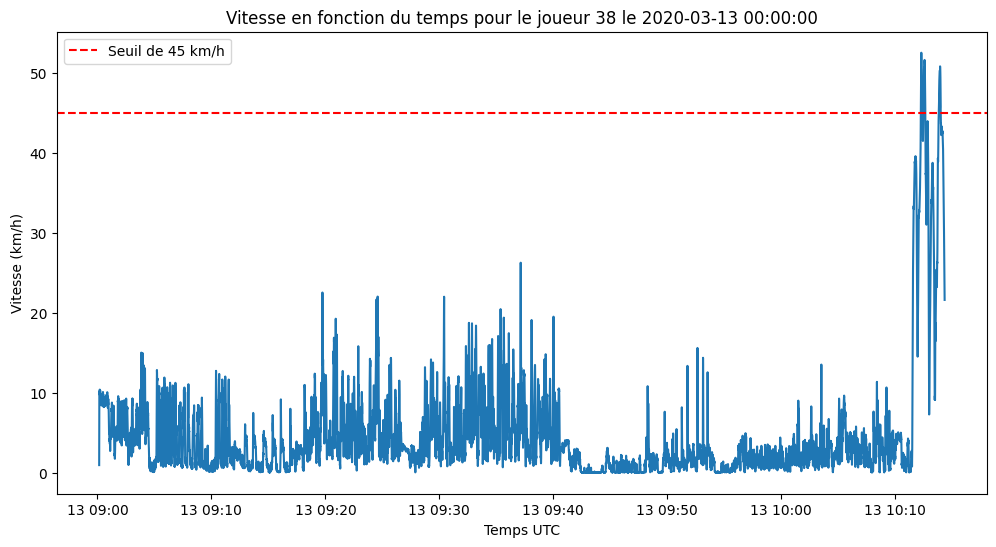

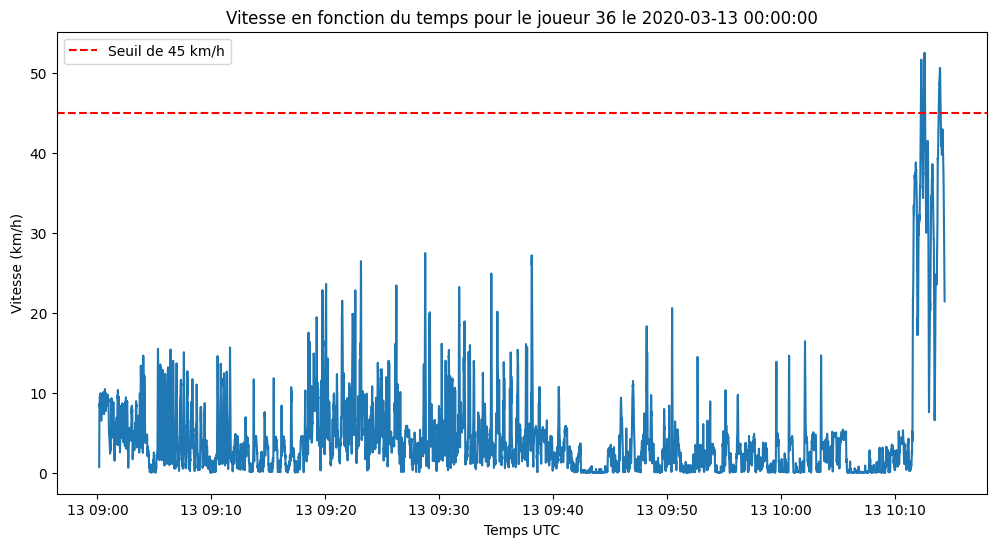

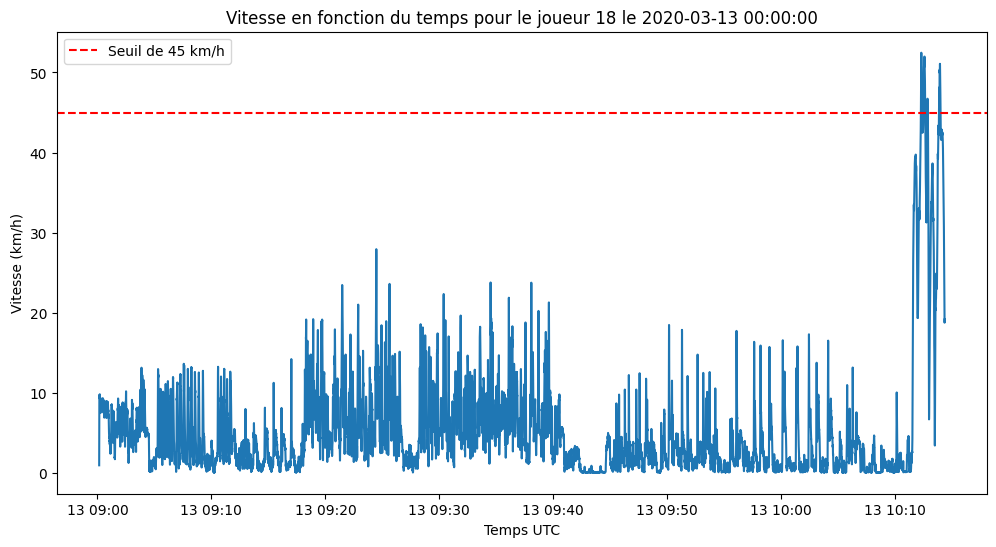

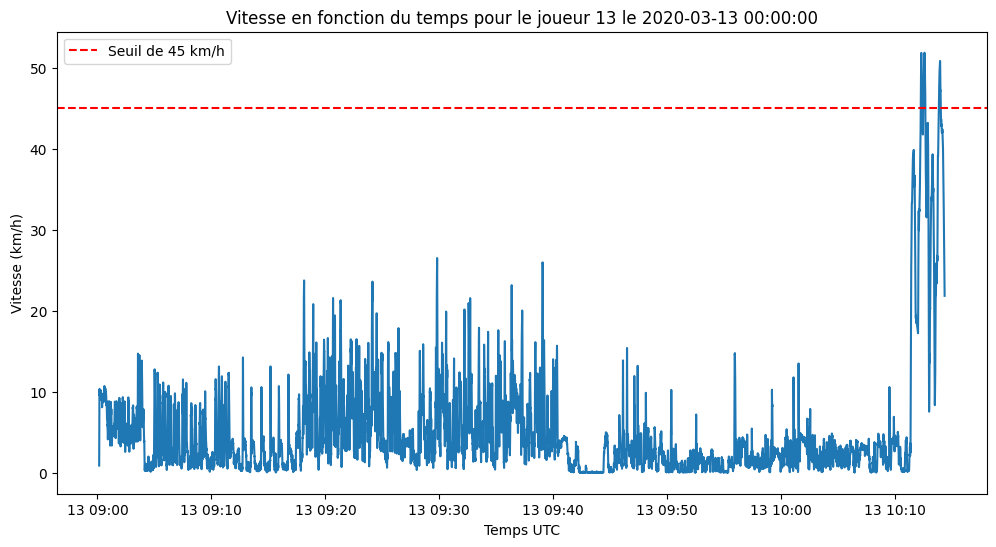

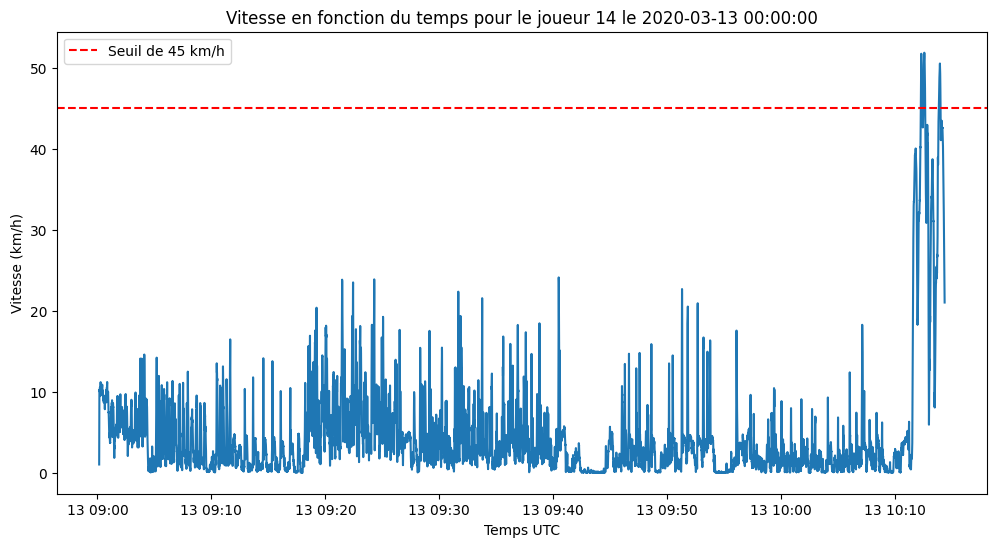

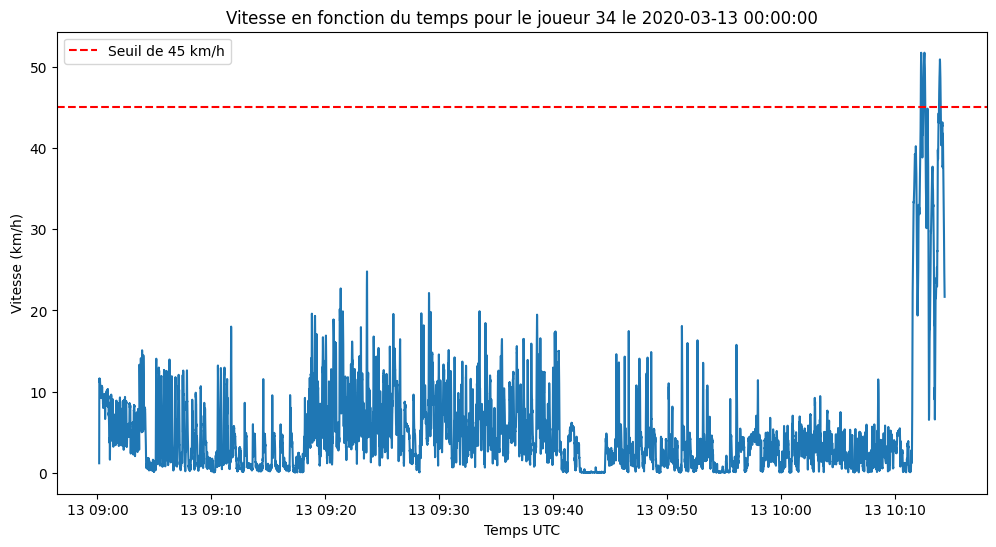

In [55]:
# Boucler sur chaque ligne de clean_vitesse
for _, row in clean_vitesse.iterrows():
    player = row['player_pseudo']
    session = row['session_date']
    
    # Récupérer les données pour ce joueur et cette session
    df_plot = con.execute(f"""
    SELECT time_utc, speed_kmh
    FROM tracking_pseudo
    WHERE player_pseudo = {player}
      AND session_date = '{session}'
    ORDER BY time_utc
    """).df()
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_plot, x='time_utc', y='speed_kmh')
    plt.title(f'Vitesse en fonction du temps pour le joueur {player} le {session}')
    plt.xlabel('Temps UTC')
    plt.ylabel('Vitesse (km/h)')
    plt.axhline(45, color='red', linestyle='--', label='Seuil de 45 km/h')
    plt.legend()
    plt.show()

Environ les 15 derière minutes le capteur bug 

Exception 9 et 18

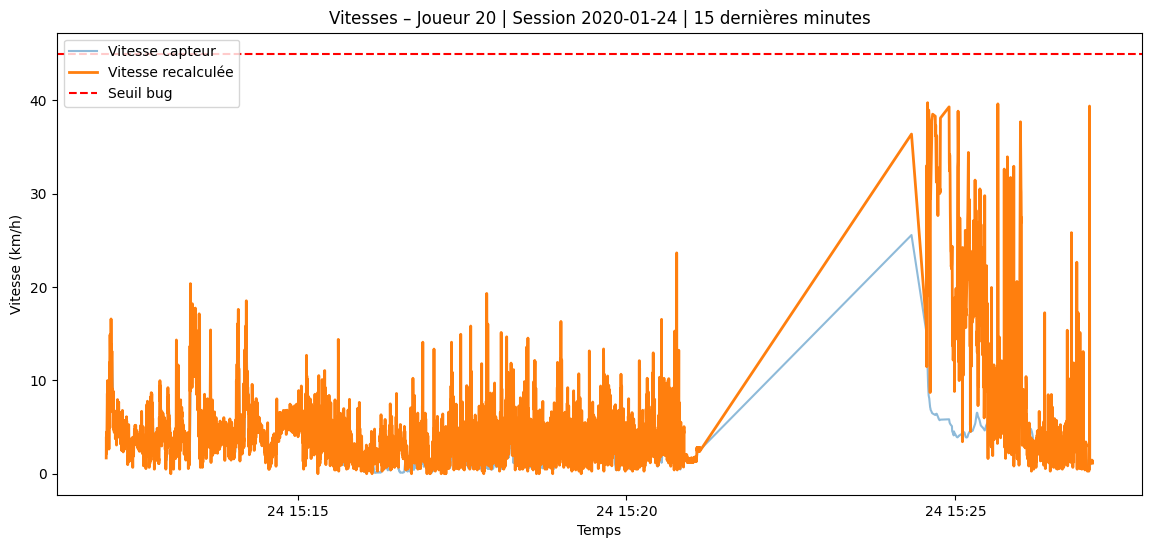

In [80]:
player = 20
session = '2020-01-24'

df_pos = con.execute(f"""
SELECT
    time_utc,
    x_pos,
    y_pos,
    speed_kmh
FROM tracking_pseudo
WHERE player_pseudo = {player}
  AND session_date = '{session}'
ORDER BY time_utc
""").df()

df_pos['time_utc'] = pd.to_datetime(df_pos['time_utc'])

t_end = df_pos['time_utc'].max()

df_last15 = df_pos[
    df_pos['time_utc'] >= t_end - pd.Timedelta(minutes=15)
].copy()

df_last15['x_prev'] = df_last15['x_pos'].shift(1)
df_last15['y_prev'] = df_last15['y_pos'].shift(1)
df_last15['t_prev'] = df_last15['time_utc'].shift(1)

# Distance (m)
df_last15['distance_m'] = np.sqrt(
    (df_last15['x_pos'] - df_last15['x_prev'])**2 +
    (df_last15['y_pos'] - df_last15['y_prev'])**2
)

# Delta temps (s)
df_last15['dt_s'] = (
    df_last15['time_utc'] - df_last15['t_prev']
).dt.total_seconds()

# Vitesse recalculée
df_last15['speed_kmh_recalc'] = (
    df_last15['distance_m'] / df_last15['dt_s']
) * 3.6

df_last15 = df_last15[
    (df_last15['dt_s'] > 0) &
    (df_last15['dt_s'] < 2) &            # cohérent capteur
    (df_last15['speed_kmh_recalc'] < 40) # plafond physiologique
]


plt.figure(figsize=(14,6))
plt.plot(
    df_last15['time_utc'],
    df_last15['speed_kmh'],
    label='Vitesse capteur',
    alpha=0.5
)
plt.plot(
    df_last15['time_utc'],
    df_last15['speed_kmh_recalc'],
    label='Vitesse recalculée',
    linewidth=2
)

plt.axhline(45, color='red', linestyle='--', label='Seuil bug')
plt.title(f'Vitesses – Joueur {player} | Session {session} | 15 dernières minutes')
plt.xlabel('Temps')
plt.ylabel('Vitesse (km/h)')
plt.legend()
plt.show()

Recalculer les points à partir des positions ne fonciotionne au regarde des autres athlètes ils n'est pas normale que seul ce joueur atteigne ces vitesse lors de l'entrainement

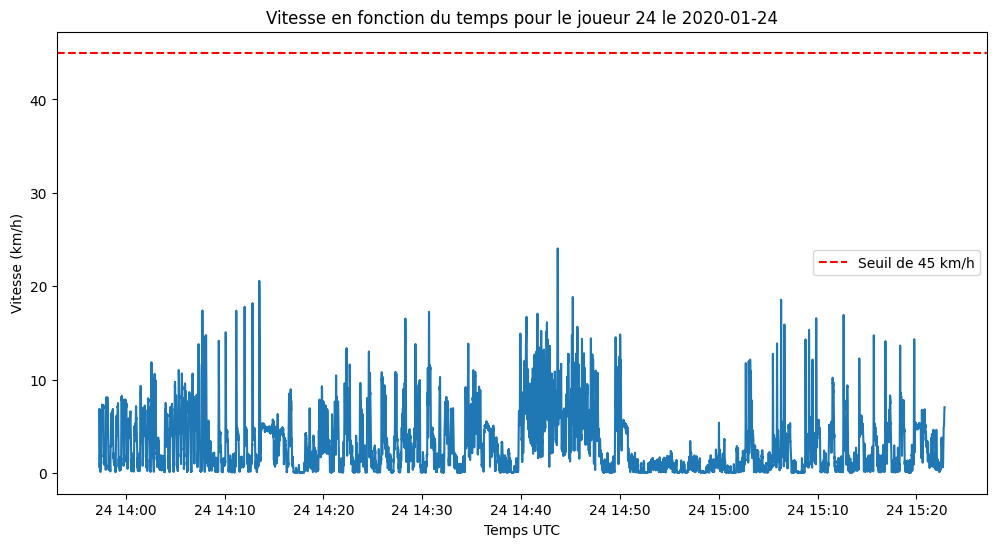

In [86]:
#Afficher vitesse en fonctiondu temps pour un joueur et une session donnés
player = 24
session = '2020-01-24'
df_pos = con.execute(f"""
SELECT
    time_utc,
    speed_kmh
FROM tracking_pseudo
WHERE player_pseudo = {player}
    AND session_date = '{session}'
ORDER BY time_utc
""").df()
df_pos['time_utc'] = pd.to_datetime(df_pos['time_utc'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pos, x='time_utc', y='speed_kmh')
plt.title(f'Vitesse en fonction du temps pour le joueur {player} le {session}')
plt.xlabel('Temps UTC')
plt.ylabel('Vitesse (km/h)')
plt.axhline(45, color='red', linestyle='--', label='Seuil de 45 km/h')
plt.legend()
plt.show()